<a href="https://colab.research.google.com/github/Munal16/Toxic-Text-Classifier-/blob/main/Toxic_Text_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas scikit-learn nltk seaborn matplotlib


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve
)

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
df = pd.read_json(
    "hf://datasets/mteb/toxic_conversations_50k/train.jsonl",
    lines=True
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
df_toxic = df[df['label'] == 1]
df_nontoxic = df[df['label'] == 0]


In [5]:
df_toxic_up = resample(
    df_toxic,
    replace=True,
    n_samples=10000,
    random_state=42
)

df_nontoxic_down = resample(
    df_nontoxic,
    replace=False,
    n_samples=20000,
    random_state=42
)


In [6]:
df_balanced = pd.concat([df_toxic_up, df_nontoxic_down])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


In [7]:
df_balanced['label'].value_counts()


,count
label,
0,20000
1,10000


In [8]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)

    tokens = word_tokenize(text)

    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words and len(word) > 2
    ]

    return " ".join(tokens)


In [9]:
df_balanced['clean_text'] = df_balanced['text'].apply(clean_text)


In [10]:
df_balanced[['text', 'clean_text']].head()


,text,clean_text
0,"Hey TDS sufferers, MAGA and he is!",hey tds sufferer maga
1,They should make it a crime to have a oil mono...,make crime oil monopoly alaska make affordable...
2,My initial thought upon reading the story was....,initial thought upon reading story wasonly cli...
3,"Thank you, Neal for your article. The state (...",thank neal article state country well politica...
4,I think the reality of the matter is that the ...,think reality matter deceased born penis matte...


In [11]:
X = df_balanced['clean_text']
y = df_balanced['label']


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [13]:
tfidf = TfidfVectorizer(
    max_features=15000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9
)


In [14]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [15]:
model_clean = LogisticRegression(
    max_iter=1000,
    random_state=42
)


In [16]:
model_clean.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [17]:
y_pred_clean = model_clean.predict(X_test_tfidf)
acc_clean = accuracy_score(y_test, y_pred_clean)

print("Accuracy:", acc_clean)


Accuracy: 0.8821666666666667


In [18]:
print(classification_report(y_test, y_pred_clean))


              precision    recall  f1-score   support

           0       0.87      0.97      0.92      4000
           1       0.91      0.72      0.80      2000

    accuracy                           0.88      6000
   macro avg       0.89      0.84      0.86      6000
weighted avg       0.89      0.88      0.88      6000



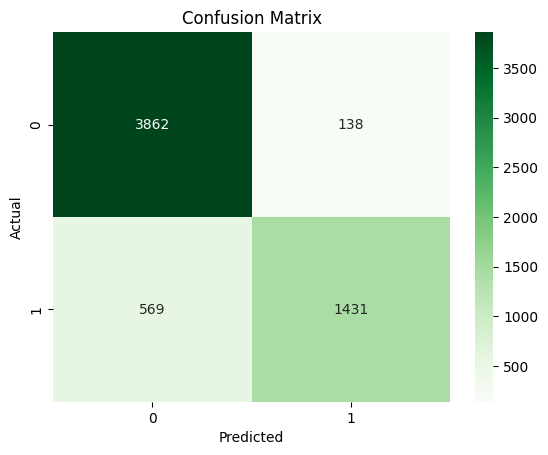

In [19]:
cm = confusion_matrix(y_test, y_pred_clean)

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


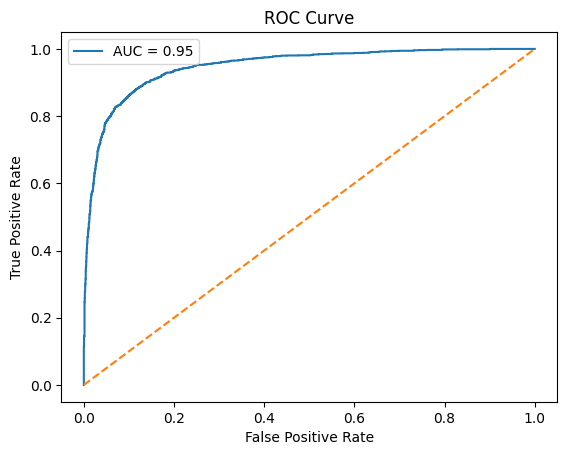

In [20]:
y_prob_clean = model_clean.predict_proba(X_test_tfidf)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob_clean)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [22]:

feature_names = tfidf.get_feature_names_out()


coefficients = model_clean.coef_[0]


feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})


In [23]:
top_toxic = feature_importance.sort_values(
    by='coefficient', ascending=False
).head(20)


plt.figure(figsize=(10,6))
plt.barh(top_toxic['feature'], top_toxic['coefficient'])
plt.gca().invert_yaxis()
plt.title("Top 20 Features Contributing to TOXIC Class")
plt.xlabel("Coefficient Weight")
plt.show()


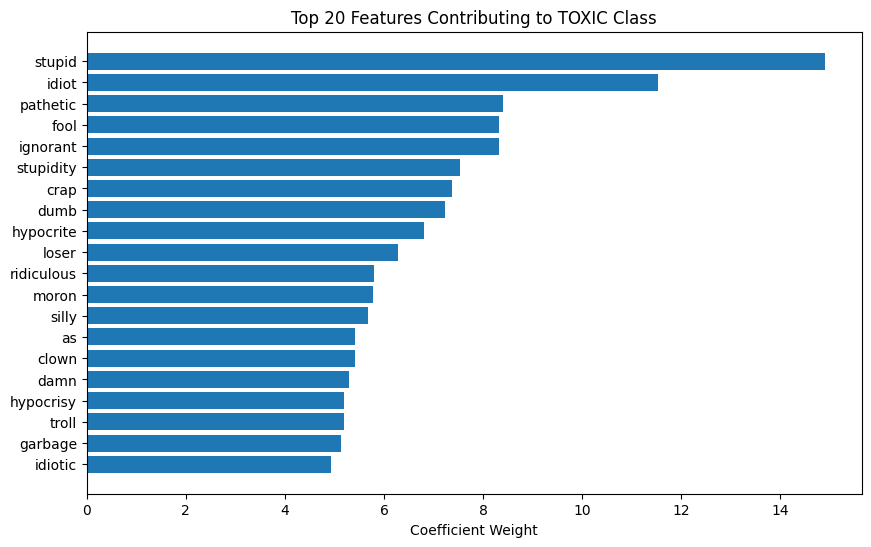

In [24]:
plt.figure(figsize=(10,6))
plt.barh(top_toxic['feature'], top_toxic['coefficient'])
plt.gca().invert_yaxis()
plt.title("Top 20 Features Contributing to TOXIC Class")
plt.xlabel("Coefficient Weight")
plt.show()


In [25]:
top_nontoxic = feature_importance.sort_values(
    by='coefficient'
).head(20)


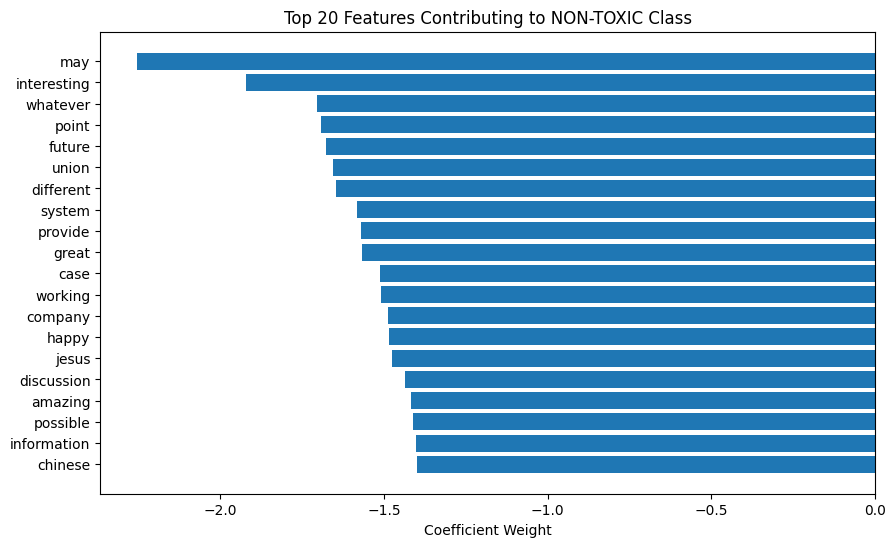

In [26]:
plt.figure(figsize=(10,6))
plt.barh(top_nontoxic['feature'], top_nontoxic['coefficient'])
plt.gca().invert_yaxis()
plt.title("Top 20 Features Contributing to NON-TOXIC Class")
plt.xlabel("Coefficient Weight")
plt.show()


In [27]:
!pip install wordcloud


In [28]:
from wordcloud import WordCloud


In [29]:
toxic_text = " ".join(
    df_balanced[df_balanced['label'] == 1]['clean_text']
)


In [30]:
wordcloud_toxic = WordCloud(
    width=800,
    height=400,
    background_color='black',
    colormap='Reds'
).generate(toxic_text)


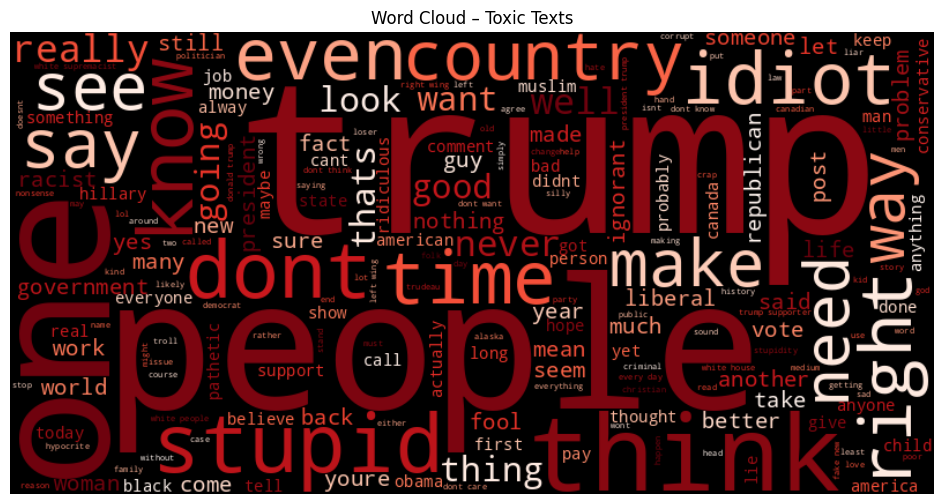

In [31]:
plt.figure(figsize=(12,6))
plt.imshow(wordcloud_toxic, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud – Toxic Texts")
plt.show()


In [32]:
nontoxic_text = " ".join(
    df_balanced[df_balanced['label'] == 0]['clean_text']
)


In [33]:
wordcloud_nontoxic = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Blues'
).generate(nontoxic_text)


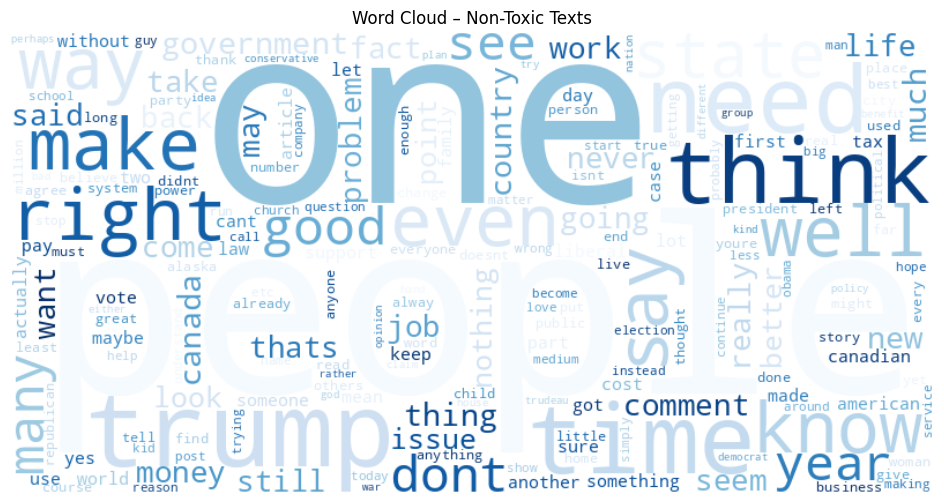

In [34]:
plt.figure(figsize=(12,6))
plt.imshow(wordcloud_nontoxic, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud – Non-Toxic Texts")
plt.show()


In [35]:
df_balanced['text_length'] = df_balanced['clean_text'].apply(lambda x: len(x.split()))


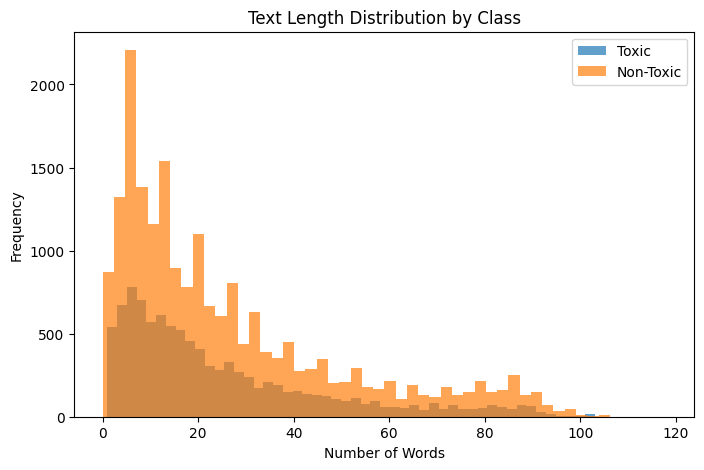

In [36]:
plt.figure(figsize=(8,5))
plt.hist(
    df_balanced[df_balanced['label'] == 1]['text_length'],
    bins=50,
    alpha=0.7,
    label='Toxic'
)

plt.hist(
    df_balanced[df_balanced['label'] == 0]['text_length'],
    bins=50,
    alpha=0.7,
    label='Non-Toxic'
)

plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.title("Text Length Distribution by Class")
plt.legend()
plt.show()


In [37]:
sample_indices = np.random.choice(len(X_test), size=10, replace=False)

sample_texts = X_test.iloc[sample_indices]
sample_labels = y_test.iloc[sample_indices]


In [38]:
sample_tfidf = tfidf.transform(sample_texts)


In [39]:
sample_preds_lr = model_clean.predict(sample_tfidf)
sample_probs_lr = model_clean.predict_proba(sample_tfidf)[:, 1]


In [40]:
lr_samples_df = pd.DataFrame({
    "Text": sample_texts.values,
    "Actual Label": sample_labels.values,
    "Predicted Label": sample_preds_lr,
    "Toxic Probability": sample_probs_lr.round(3)
})

lr_samples_df


,Text,Actual Label,Predicted Label,Toxic Probability
0,nonprofit effectively manage expense lend comp...,0,0,0.096
1,since private company governed provincial regu...,0,0,0.053
2,caribou population fluctuate established fact ...,0,0,0.073
3,check new zealand australian even british pape...,0,0,0.072
4,actually law people forced get mental health h...,0,0,0.359
5,must really kill progressive liberal alaska re...,1,1,0.529
6,actually good ideamake possible alaskan choose...,0,0,0.185
7,trump look like big talking bluffer north kore...,0,0,0.396
8,true ignores fact dont lay people reduce numbe...,0,0,0.067
9,happy see people best line article highlighted...,0,0,0.144


In [41]:
from sklearn.model_selection import learning_curve


In [42]:
train_sizes, train_scores, test_scores = learning_curve(
    model_clean,
    X_train_tfidf,
    y_train,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)


In [43]:
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)


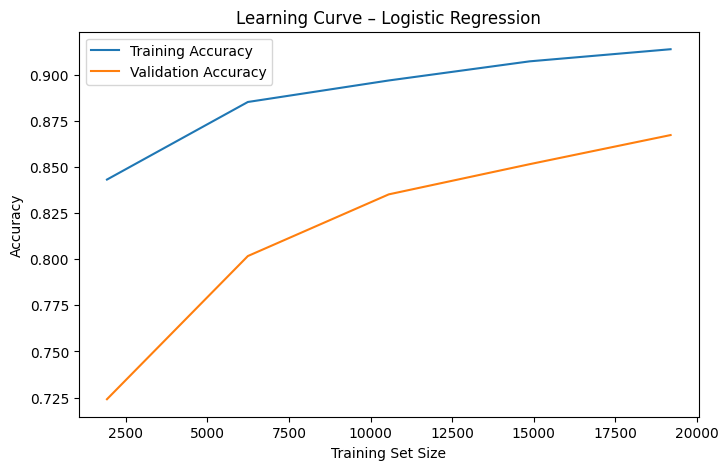

In [44]:
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.plot(train_sizes, test_mean, label="Validation Accuracy")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve – Logistic Regression")
plt.legend()
plt.show()
